<a href="https://colab.research.google.com/github/Bibhash123/SC-Lab-Project/blob/main/SC_Lab_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp "/content/kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d "/content/data"
!rm -r chest-xray-pneumonia.zip

Saving kaggle (1).json to kaggle (1).json
100% 2.29G/2.29G [00:39<00:00, 92.0MB/s]
100% 2.29G/2.29G [00:39<00:00, 61.6MB/s]


In [2]:
import os
import numpy as np
import glob
import seaborn as sns
import cv2
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from functools import partial

In [3]:
train_files = glob.glob(os.path.join("/content/data/chest_xray/train/","**/*.jpeg"),recursive = True)
test_files = glob.glob(os.path.join("/content/data/chest_xray/test/","**/*.jpeg"),recursive = True)
np.random.shuffle(train_files)
np.random.shuffle(test_files)

In [4]:
dic = {'NORMAL':0,"PNEUMONIA":1}
rev_dic = {0:"NORMAL",1:"PNEUMONIA"}
getLabel = lambda x: dic[x.split("/")[-2]]

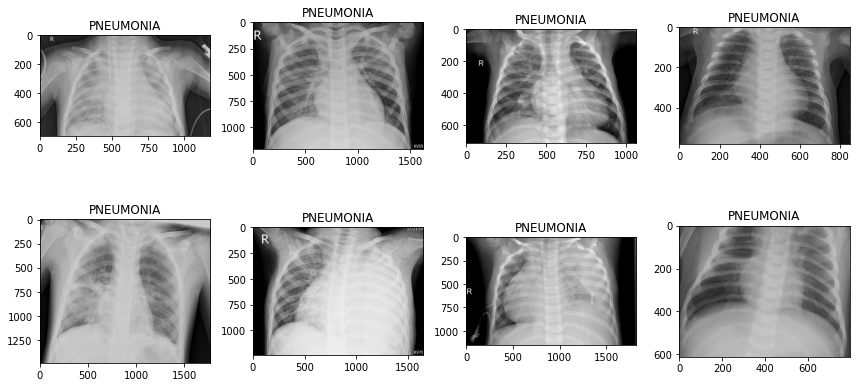

In [5]:
fig,ax = plt.subplots(2,4,figsize = (12,6))
ax = ax.flatten()

for i in range(8):
  img = cv2.cvtColor(cv2.imread(train_files[i]),cv2.COLOR_BGR2RGB)
  ax[i].imshow(img)
  ax[i].set_title(rev_dic[getLabel(train_files[i])])

plt.tight_layout()
plt.show()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         2359424   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 2048)              0      

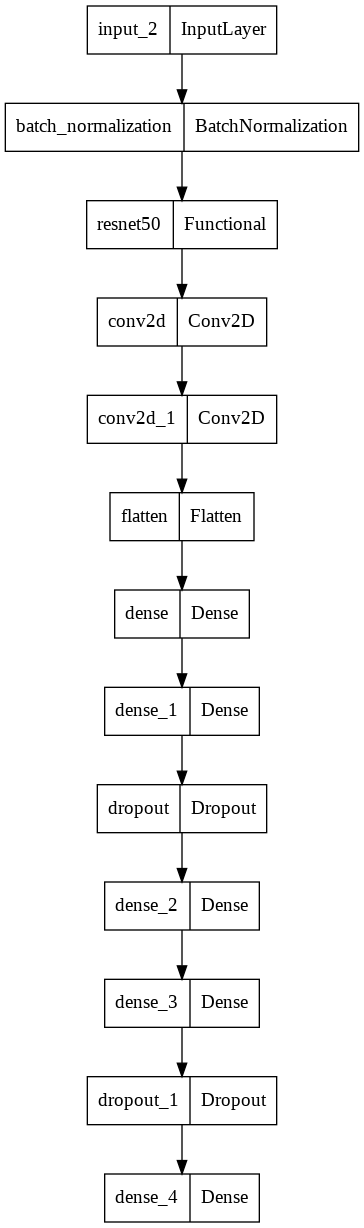

In [6]:
backbone = tf.keras.applications.resnet.ResNet50(input_shape = (128,128,3), weights='imagenet', include_top = False)

inp = L.Input(shape = (128,128,3))
h = L.BatchNormalization()(inp)
h = backbone(h)
h = L.Conv2D(128,3, padding = 'same', activation = "relu")(h)
h = L.Conv2D(128,3, padding = 'same', activation = "relu")(h)
h = L.Flatten()(h)
h = L.Dense(256, activation = "relu")(h)
h = L.Dense(256, activation = "relu")(h)
h = L.Dropout(0.7)(h)
h = L.Dense(256, activation = "relu")(h)
h = L.Dense(256, activation = "relu")(h)
h = L.Dropout(0.7)(h)
h = L.Dense(1,activation = "sigmoid")(h)

model = tf.keras.models.Model(inputs = inp, outputs = h)
model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ["accuracy"])
model.summary()
tf.keras.utils.plot_model(model,)

In [7]:
train_labels = list(map(getLabel,train_files))
test_labels = list(map(getLabel,test_files))

def preprocess_input(im_file, target_size, scale=255.):
    """ 
        Read image
        Arguments:
            im_file     : input image file
            target_size : output size of the image (height, width)
        Returns: The image
    """
    file_bytes = tf.io.read_file(im_file)
    img = tf.image.decode_jpeg(file_bytes, channels = 3)
    # Normalize and Resize
    if img.shape != target_size:
        img = tf.image.resize(img, target_size)
    return img

AUTOTUNE = tf.data.experimental.AUTOTUNE

def build_decoder(is_labelled):
    def if_labelled(path, label, target_size):
        image = preprocess_input(path,target_size)
        # qf = getQFRange(qf1)
        return image, label
  
    def not_labelled(path,target_size):
        image = preprocess_input(path,target_size)
        return image  

    return if_labelled if is_labelled else not_labelled


def create_dataset(filenames, labels, batch_size = 32, is_labelled = False, repeat = False, shuffle = False, batch=False, cache=False):
    decode_fn = build_decoder(is_labelled)
    
    # Create Dataset
    if is_labelled:
      dataset = tf.data.Dataset.from_tensor_slices((filenames,labels))
    else:
      dataset = tf.data.Dataset.from_tensor_slices((filenames))

    dataset = dataset.map(partial(decode_fn,target_size=(128,128)), num_parallel_calls = AUTOTUNE)
    dataset = dataset.cache("") if cache else dataset
    dataset = dataset.repeat() if repeat else dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration = True) if shuffle else dataset
    dataset = dataset.batch(batch_size,drop_remainder=True) if batch else dataset
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [9]:
train_set = create_dataset(train_files,
                           train_labels,
                           batch_size = 32,
                           is_labelled = True,
                           repeat = True,
                           shuffle = False,
                           batch=True,
                           cache=True)

test_set = create_dataset(test_files,
                           test_labels,
                           batch_size = 32,
                           is_labelled = True,
                           repeat = False,
                           shuffle = False,
                           batch=True,
                           cache=True
                           )

In [10]:
ckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5',save_best_only = True, save_weights_only = True,
                                           monitor = "val_accuracy", mode = 'max')
es = tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_accuracy', mode='max')

history = model.fit(train_set,
          epochs = 100,
          steps_per_epoch = len(train_files)//32,
          validation_data = test_set,
          callbacks = [ckpt,es]
)

Epoch 1/100
163/163 [==============================] - 88s 321ms/step - loss: 0.3618 - accuracy: 0.8992 - val_loss: 5.6676 - val_accuracy: 0.6299
Epoch 2/100
163/163 [==============================] - 50s 307ms/step - loss: 0.1591 - accuracy: 0.9574 - val_loss: 58.4877 - val_accuracy: 0.6299
Epoch 3/100
163/163 [==============================] - 50s 307ms/step - loss: 0.1137 - accuracy: 0.9676 - val_loss: 173.0835 - val_accuracy: 0.6299
Epoch 4/100
163/163 [==============================] - 53s 324ms/step - loss: 0.0598 - accuracy: 0.9768 - val_loss: 11.8966 - val_accuracy: 0.6316
Epoch 5/100
163/163 [==============================] - 51s 312ms/step - loss: 0.0969 - accuracy: 0.9701 - val_loss: 75.0450 - val_accuracy: 0.7138
Epoch 6/100
163/163 [==============================] - 49s 299ms/step - loss: 0.1889 - accuracy: 0.9369 - val_loss: 122.5019 - val_accuracy: 0.6299
Epoch 7/100
163/163 [==============================] - 49s 301ms/step - loss: 0.1562 - accuracy: 0.9484 - val_loss: 0

In [13]:
def getX(X,Y):
    return X
def getY(X,Y):
    return Y

Y_test = test_set.map(getY)
Y_test = np.array(list(Y_test.unbatch().as_numpy_iterator()))

model.load_weights('model.hdf5')
Y_pred = model.predict(test_set)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,(Y_pred>0.5).astype(int))

0.8700657894736842

In [14]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
trn_acc = history.history['accuracy']
trn_loss = history.history['loss']

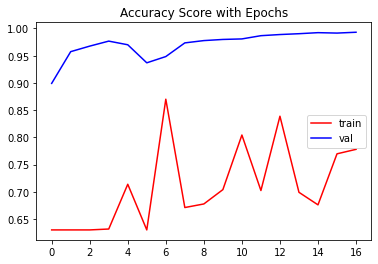

In [15]:
plt.plot(range(len(val_acc)),val_acc, c='red',label = 'train')
plt.plot(range(len(val_acc)),trn_acc, c='blue',label = 'val')
plt.title("Accuracy Score with Epochs")
plt.legend()

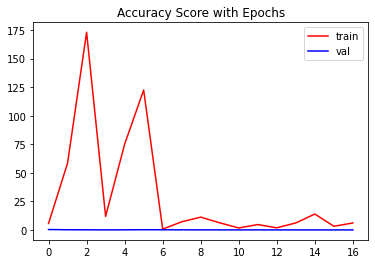

In [16]:
plt.plot(range(len(val_acc)),val_loss, c='red',label = 'train')
plt.plot(range(len(val_acc)),trn_loss, c='blue',label = 'val')
plt.title("Accuracy Score with Epochs")
plt.legend()